In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# XEB calibration: Example and benchmark

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/noise/qcvv/xeb_calibration_example"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/noise/qcvv/xeb_calibration_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/noise/qcvv/xeb_calibration_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/noise/qcvv/xeb_calibration_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This tutorial shows a detailed example and benchmark of XEB calibration, a calibration technique introduced in the [Calibration: Overview and API](../calibration_api.ipynb) tutorial.

**Disclaimer**: The data shown in this tutorial is exemplary and not representative of the QCS in production.

## Setup

Note: this notebook relies on unreleased Cirq features. If you want to try these features, make sure you install cirq via `pip install cirq --pre`.

In [3]:
try:
    import cirq
except ImportError:
    !pip install --quiet cirq --pre

     |████████████████████████████████| 1.5MB 4.9MB/s 
     |████████████████████████████████| 399kB 28.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 1.3MB 37.7MB/s 


In [ ]:
# The Google Cloud Project id to use.
project_id = "" #@param {type:"string"}
processor_id = "" #@param {type:"string"}

from cirq_google.engine.qcs_notebook import get_qcs_objects_for_notebook
device_sampler = get_qcs_objects_for_notebook(project_id, processor_id)

if not device_sampler.signed_in:
    raise Exception("Please setup project_id in this cell or set the `GOOGLE_CLOUD_PROJECT` env var to your project id.")

In [5]:
import cirq
from cirq.experiments import random_quantum_circuit_generation as rqcg
import cirq_google as cg

import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [6]:
#@title Helper functions
from typing import Optional, Sequence


def create_random_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.FSimGate(np.pi / 4, 0.0),
    seed: Optional[int] = None,
) -> cirq.Circuit:
    return rqcg.random_rotations_between_grid_interaction_layers_circuit(
        qubits, 
        depth=cycles,
        two_qubit_op_factory=lambda a, b, _: twoq_gate.on(a, b),
        pattern=cirq.experiments.GRID_STAGGERED_PATTERN,
        single_qubit_gates=[cirq.PhasedXPowGate(phase_exponent=p, exponent=0.5)
                            for p in np.arange(-1.0, 1.0, 0.25)],
        seed=seed
    )



def create_loschmidt_echo_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.FSimGate(np.pi / 4, 0.0),
    seed: Optional[int] = None,
) -> cirq.Circuit:
    """Returns a Loschmidt echo circuit using a random unitary U.

    Args:
        qubits: Qubits to use.
        cycles: Depth of random rotations in the forward & reverse unitary.
        twoq_gate: Two-qubit gate to use.
        pause: Optional duration to pause for between U and U^\dagger.
        seed: Seed for circuit generation.
    """
    forward = create_random_circuit(qubits, cycles, twoq_gate, seed)
    return forward + cirq.inverse(forward) + cirq.measure(*qubits, key="z")



def to_ground_state_prob(result: cirq.Result) -> float:
    return np.mean(np.sum(result.measurements["z"], axis=1) == 0)

## Select qubits

First we select a processor and calibration metric(s) to visualize the latest calibration report.

Note: All calibration metrics are defined in [this guide](https://quantumai.google/cirq/google/calibration). The `parallel_p00_error` and/or `parallel_p11_error` metrics are good to eliminate qubits with high readout errors.

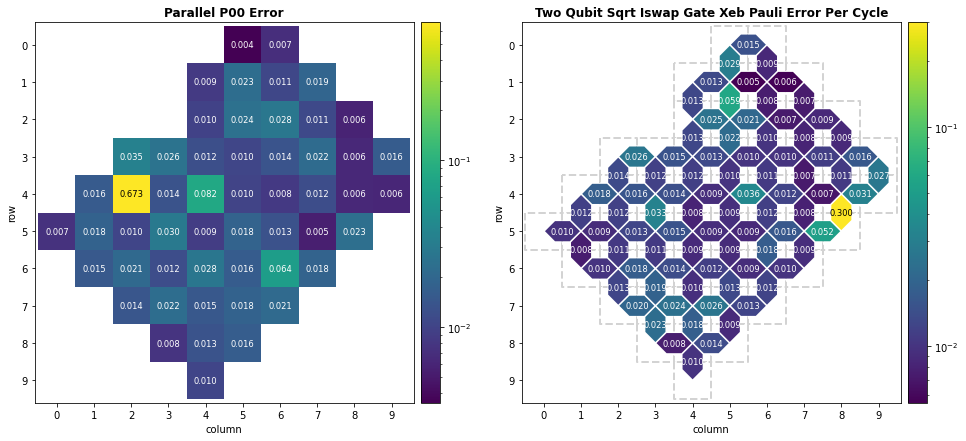

In [7]:
processor_id = "" #@param {type:"string"}
metrics = "parallel_p00_error, two_qubit_sqrt_iswap_gate_xeb_pauli_error_per_cycle" #@param {type:"string"}
metrics = [m.strip() for m in metrics.split(sep=",")]

from matplotlib.colors import LogNorm


_, axes = plt.subplots(
    nrows=1, ncols=len(metrics), figsize=(min(16, 8 * len(metrics)), 7)
)


calibration = cg.get_engine_calibration(processor_id=processor_id)
for i, metric in enumerate(metrics):
    calibration.heatmap(metric).plot(
        ax=axes[i] if len(metrics) > 1 else axes, 
        collection_options={"norm": LogNorm()}, 
        annotation_format="0.3f", 
        annotation_text_kwargs = {"size": "small"}
);

Using this report as a guide, we select a good set of qubits.

In [8]:
# Select qubit indices here.
qubit_indices = [
    (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), 
    (3, 7), (3, 6), (3, 5), (4, 5), (4, 6)  
]
qubits = [cirq.GridQubit(*idx) for idx in qubit_indices]

An example random circuit on these qubits (used as the forward operations of the Loschmidt echo) is shown below.


In [9]:
create_random_circuit(qubits, cycles=10, seed=1)

┌──────────────────────────────────────────┐                    ┌────────────────────────────┐                                                                                                                                                           ┌──────────────────────────────────────────┐                    ┌────────────────────────────┐                    ┌──────────────────────────────────────────┐                    ┌────────────────────────────┐
(2, 5): ───PhX(-0.5)^0.5───────────────────────────────────────────────────PhX(-0.25)^0.5────FSim(0.25π, 0)──────────────────PhX(1)^0.5───────FSim(0.25π, 0)───PhX(-0.5)^0.5─────────────────────PhX(1)^0.5───────FSim(0.25π, 0)───PhX(0.75)^0.5────────────────────PhX(0)^0.5──────────────────────────────────────────────────────PhX(-0.5)^0.5─────FSim(0.25π, 0)──────────────────PhX(0.25)^0.5───────────────────────────────────────────────────PhX(0.5)^0.5──────FSim(0.25π, 0)──────────────────PhX(-0.75)^0.5───
                                                                                             │                                                │                                                                   │                                                                                                                                   │                                                                                                                 │
(2, 6): ───PhX(0)^0.5────────FSim(0.25π, 0)────────────────────────────────PhX(0.5)^0.5──────┼───────────────────────────────PhX(-0.5)^0.5────FSim(0.25π, 0)───PhX(-0.75)^0.5───FSim(0.25π, 0)───PhX(0.75)^0.5────FSim(0.25π, 0)───PhX(0.5)^0.5────FSim(0.25π, 0)───PhX(0)^0.5────────FSim(0.25π, 0)────────────────────────────────PhX(-0.25)^0.5────┼───────────────────────────────PhX(-0.5)^0.5─────FSim(0.25π, 0)────────────────────────────────PhX(0.25)^0.5─────┼───────────────────────────────PhX(1)^0.5───────
                             │                                                               │                                                                                  │                                                                  │                                  │                                                               │                                                 │                                                               │
(2, 7): ───PhX(0.75)^0.5─────┼─────────────────────────────────────────────PhX(0)^0.5────────┼─────────────FSim(0.25π, 0)────PhX(-0.25)^0.5───FSim(0.25π, 0)───PhX(-0.75)^0.5───FSim(0.25π, 0)───PhX(0.75)^0.5────FSim(0.25π, 0)───PhX(0.5)^0.5────FSim(0.25π, 0)───PhX(-0.75)^0.5────┼─────────────────────────────────────────────PhX(-0.5)^0.5─────┼─────────────FSim(0.25π, 0)────PhX(0.25)^0.5─────┼─────────────────────────────────────────────PhX(0)^0.5────────┼─────────────FSim(0.25π, 0)────PhX(-0.75)^0.5───
                             │                                                               │             │                                  │                                                                   │                                                                   │                                                               │             │                                   │                                                               │             │
(2, 8): ───PhX(0.75)^0.5─────┼─────────────FSim(0.25π, 0)──────────────────PhX(1)^0.5────────┼─────────────┼─────────────────PhX(0)^0.5───────FSim(0.25π, 0)───PhX(-0.25)^0.5────────────────────PhX(0.5)^0.5─────FSim(0.25π, 0)───PhX(-0.5)^0.5────────────────────PhX(-0.25)^0.5────┼─────────────FSim(0.25π, 0)──────────────────PhX(0.75)^0.5─────┼─────────────┼─────────────────PhX(-0.75)^0.5────┼─────────────FSim(0.25π, 0)──────────────────PhX(-0.5)^0.5─────┼─────────────┼─────────────────PhX(0.25)^0.5────
                             │             │                                                 │             │                      

## Set up XEB calibration

Now we specify the cycle depths and other options for XEB calibration below. Note that all `cirq.FSimGate` parameters are characterized by default.

In [11]:
xeb_options = cg.LocalXEBPhasedFSimCalibrationOptions(
    cycle_depths=(5, 25, 50, 100),
    n_processes=1,
    fsim_options=cirq.experiments.XEBPhasedFSimCharacterizationOptions(
        characterize_theta=False,
        characterize_zeta=True,
        characterize_chi=True,
        characterize_gamma=True,
        characterize_phi=False,
    ),
)

## Run a Loschmidt echo benchmark

Note: See the [Loschmidt echo tutorial](https://quantumai.google/cirq/tutorials/google/echoes) for background about this benchmark.

In [12]:
"""Setup the Loschmidt echo experiment."""
cycle_values = range(0, 40 + 1, 4)
nreps = 20_000
trials = 10

sampler = cg.get_engine_sampler(
    project_id=project_id,
    processor_id=processor_id, 
    gate_set_name="sqrt_iswap",
)

loschmidt_echo_batch = [
    create_loschmidt_echo_circuit(qubits, cycles=c, seed=trial)
    for trial in range(trials) for c in cycle_values
]

### Without calibration

First we run the Loschmidt echo without calibration.

In [13]:
# Run on the engine.
raw_results = sampler.run_batch(programs=loschmidt_echo_batch, repetitions=nreps)

# Convert measurements to survival probabilities.
raw_probs = np.array(
    [to_ground_state_prob(*res) for res in raw_results]
).reshape(trials, len(cycle_values))

### With XEB calibration

Now we perform XEB calibration.

In [14]:
# Get characterization requests.
characterization_requests = cg.prepare_characterization_for_operations(loschmidt_echo_batch, xeb_options)

# Characterize the requests on the engine.
characterizations = cg.run_calibrations(characterization_requests, sampler)

# Make compensations to circuits in the Loschmidt echo batch.
xeb_calibrated_batch = [
    cg.make_zeta_chi_gamma_compensation_for_moments(circuit, characterizations).circuit
    for circuit in loschmidt_echo_batch
]

100%|██████████| 45/45 [02:24<00:00,  3.20s/it]


And run the XEB calibrated batch below.

In [15]:
# Run on the engine.
xeb_results = sampler.run_batch(programs=xeb_calibrated_batch, repetitions=nreps)

# Convert measurements to survival probabilities.
xeb_probs = np.array(
    [to_ground_state_prob(*res) for res in xeb_results]
).reshape(trials, len(cycle_values))

### Compare results

The next cell plots the results.

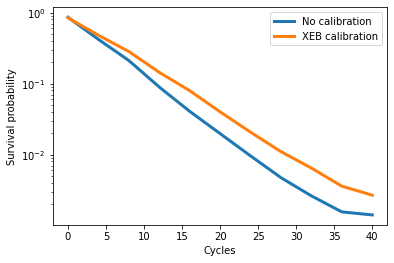

In [16]:
plt.semilogy(cycle_values, np.average(raw_probs, axis=0), lw=3, label="No calibration")
plt.semilogy(cycle_values, np.average(xeb_probs, axis=0), lw=3, label="XEB calibration")

plt.xlabel("Cycles")
plt.ylabel("Survival probability")
plt.legend();

A smaller (in magnitude) slope indicates lower two-qubit gate errors. You should see that XEB calibration produces lower errors than no calibration in the Loschmidt echo benchmark.